## Image Momenta Dataset Building from csv files

Here we are going to create the datasets using the files Waldo_Mom_df.csv, NW_Mom_df.csv, DomW_moments_df.csv and DomNW_moments_df.csv. Obviously, W refers to Waldo and NW to Non Waldo

In [1]:
# loading packages

# Almost default packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# From scikit learn we need to properly split our dataset
# as well as to perform Principal Component Analysis
# and other stuff
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Import OpenCV package. Important for Moment calculations
import cv2

# Inline plotting
%matplotlib inline

While pretty much all the work I did today has gone to shit, I was lucky enough to have saved the datasets. So, we read the datasets.

In [16]:
# For the moments of unmanipulated images
Waldo_Mom_df = pd.read_csv('Waldo_Mom_df.csv')
NW_Mom_df = pd.read_csv('NW_Mom_df.csv')

# For the moments from dominant channel images
DomW_moments_df = pd.read_csv('DomW_moments_df.csv')
DomNW_moments_df = pd.read_csv('DomNW_moments_df.csv')

# For completeness and just to make me feel slightly better,
# I also load the greyscale dataset (Fuck that set, but I built it
# and it took several hours of my life that I wont get back)
# This are commented out
# GreyW_moments_df = pd.read_csv('GreyW_moments_df.csv')
# GreyNW_moments_df = pd.read_csv('GreyNW_moments_df.csv')

# There is also the flattened pixels, but that data set is unreasonably huge
# so screw that.

In [17]:
# In order to create the Full Dataset, we need to clean a couple issues in
# the DataFrames

# NW DataFrames contain some few NaN values
print('Nan values before',sum(np.isnan(NW_Mom_df).any()))
NW_Mom_df.fillna(0, inplace=True)
DomNW_moments_df.fillna(0, inplace=True)
# GreyNW_moments_df.fillna(0, inplace=True)
print('Nan values after',sum(np.isnan(NW_Mom_df).any()))

Nan values before 18
Nan values after 0


In [19]:
# Now the Full Dataset will consist of the union of the datagrames of momenta
# from untouched and dominant channel images. As the csv files do contain a
# 'Waldo' column, this has to be removed previously from all DataFrames

Waldo_Mom_df.drop('Waldo', inplace=True, axis=1)
NW_Mom_df.drop('Waldo', inplace=True, axis=1)

DomW_moments_df.drop('Waldo', inplace=True, axis=1)
DomNW_moments_df.drop('Waldo', inplace=True, axis=1)

# GreyW_moments_df.drop('Waldo', inplace=True, axis=1)
# GreyNW_moments_df.drop('Waldo', inplace=True, axis=1)

In [21]:
# Now we join the Waldo DataFrames, and the NW DataFrames
Full_Waldo_df = pd.concat([Waldo_Mom_df, DomW_moments_df], axis=1).reindex(Waldo_Mom_df.index)
Full_NW_df = pd.concat([NW_Mom_df, DomNW_moments_df], axis=1).reindex(NW_Mom_df.index)

# And add the appropriate 'Waldo' column to each one
Full_Waldo_df['Waldo'] = 1
Full_NW_df['Waldo'] = 0

In [29]:
# And finally we join them together into the DataFrame to end all DataFrames
# the mythical Full_data
Full_data = pd.concat([Full_Waldo_df,Full_NW_df])

In [30]:
# Just to showcase everything is correct so far
Full_data.head()

,m00_R,m00_G,m00_B,m01_R,m01_G,m01_B,m02_R,m02_G,m02_B,m03_R,...,Dom_Hu_R5,Dom_Hu_G5,Dom_Hu_B5,Dom_Hu_R6,Dom_Hu_G6,Dom_Hu_B6,Dom_Hu_R7,Dom_Hu_G7,Dom_Hu_B7,Waldo
0,562776.0,461394.0,382607.0,18138800.0,15424857.0,13639027.0,775775802.0,677082273.0,618883295.0,3.701347e+10,...,20.972615,-17.729665,19.411863,14.595944,11.043253,-12.617343,21.140961,-16.574997,19.408328,1
1,688026.0,588902.0,265397.0,19546113.0,16848042.0,10006205.0,805598451.0,699274538.0,458527775.0,3.836533e+10,...,-22.240984,15.535643,15.297742,-15.021387,10.494301,10.444699,22.958618,16.023717,-16.326731,1
2,651908.0,551485.0,277243.0,19102730.0,16195169.0,9899127.0,806092576.0,681050005.0,430645187.0,3.869725e+10,...,-22.040053,-16.155986,15.547229,-14.946080,10.898386,10.620027,23.110656,15.867266,15.947216,1
3,563067.0,503787.0,392931.0,17974219.0,16710993.0,14066108.0,758159727.0,723354485.0,641071258.0,3.586437e+10,...,21.430712,-16.329048,-19.346919,-15.794456,11.067559,-12.291619,21.848960,-16.438878,-18.603020,1
4,673054.0,543029.0,262571.0,19869665.0,15594103.0,9062231.0,835994465.0,651516061.0,397979875.0,4.004752e+10,...,-24.495910,18.079019,16.658940,-16.552379,-12.423307,11.524571,-24.135692,-18.552852,-16.720203,1


### Ok, now we do have the Dataset and can proceed with analysis

In [32]:
# Do the test - train split
X_train, X_test, y_train, y_test = train_test_split(Full_data.iloc[:,:-1],Full_data['Waldo'],
                                                 test_size = .25,random_state = 614,shuffle = True)

In [35]:
# Fit the PCA algorithm
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

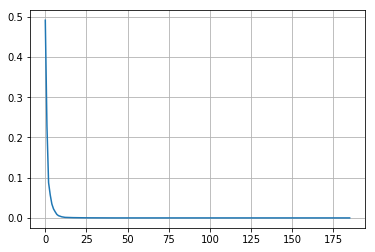

In [38]:
# Visualize the explained variance
Exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(Exp_var.size), 1 - Exp_var)
plt.grid()

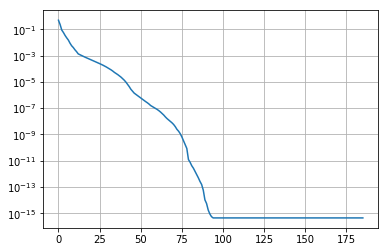

In [39]:
# Now in logarithmic scale
Exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(Exp_var.size), 1 - Exp_var)
plt.yscale('log')
plt.grid()

In [40]:
# We take 60 components, a little overkill but
# better be safe than sorry

# Lets create the pipeline for this case
pca_pipe_n60 = Pipeline([('scaler',StandardScaler()), ('pca',PCA(n_components=60))])

# Fit PCA using ONLY the train set
pca_pipe_n60.fit(X_train)

# And with the obtained components we project the sets
X_pca60_train = pca_pipe_n60.transform(X_train)
X_pca60_test = pca_pipe_n60.transform(X_test)

# It is important to use transform and not fit transform. I believe
# scikit is smart enough to avoid fitting the model twice, but it 
# should be noted

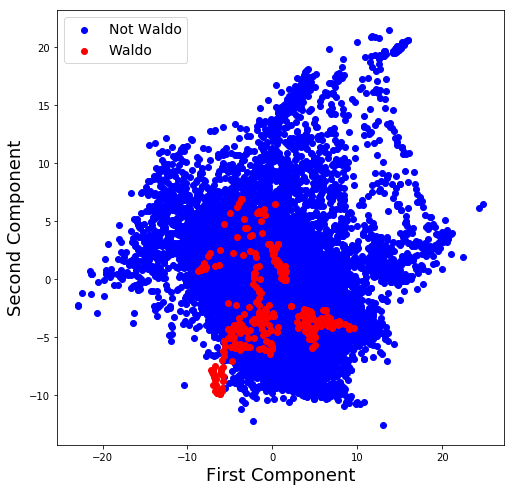

In [41]:
# Now we check the component projections
plt.figure(figsize = (8,8))

plt.scatter(X_pca60_train[y_train==0,0],X_pca60_train[y_train==0,1],c='blue',label='Not Waldo')
plt.scatter(X_pca60_train[y_train==1,0],X_pca60_train[y_train==1,1],c='red',label='Waldo')

plt.legend(fontsize=14)
plt.xlabel("First Component",fontsize=18)
plt.ylabel("Second Component",fontsize=18)

plt.show()

### This is the best dataset I have been able to construct !!
Now we proceed to perform the K-Neighbors classification

In [42]:
# Now we can proceed with the Knn algorithm and check results
# The number of K-Neighbors is sampled
# Save a list of Knn fits, Knn predictions of the test set and scores
Knn_fits_u = []
Knn_pred_u = []
Knn_scor_u = []

for i in range(1,11):
    knn_pca_u = KNeighborsClassifier(n_neighbors=i, weights='uniform', n_jobs=-1)
    knn_pca_u.fit(X_pca60_train, y_train)
    Train_score = knn_pca_u.score(X_pca60_train, y_train)
    Test_score = knn_pca_u.score(X_pca60_test, y_test)
    Knn_fits_u.append(knn_pca_u)
    Knn_pred_u.append(knn_pca_u.predict(X_pca60_test))
    Knn_scor_u.append([i, Train_score, Test_score])
    print(i, Train_score, Test_score)

1 1.0 0.989075018208303
2 0.9999190742089504 0.9946588977907259
3 0.9944161204175771 0.9893177955814518
4 0.996924819940115 0.9929594561786842
5 0.9935259367160314 0.9900461277008983
6 0.9954681557012219 0.9941733430444283
7 0.9936877882981306 0.9910172371934935
8 0.9948207493728252 0.9941733430444283
9 0.9934450109249818 0.9922311240592376
10 0.9953063041191228 0.9944161204175771


In [43]:
# The same, but this time we use the distance as weights
Knn_fits_d = []
Knn_pred_d = []
Knn_scor_d = []

for i in range(1,11):
    knn_pca_d = KNeighborsClassifier(n_neighbors=i, weights='distance', n_jobs=-1)
    knn_pca_d.fit(X_pca60_train, y_train)
    Train_score = knn_pca_d.score(X_pca60_train, y_train)
    Test_score = knn_pca_d.score(X_pca60_test, y_test)
    Knn_fits_d.append(knn_pca_d)
    Knn_pred_d.append(knn_pca_d.predict(X_pca60_test))
    Knn_scor_d.append([i, Train_score, Test_score])
    print(i, Train_score, Test_score)

1 1.0 0.989075018208303
2 1.0 0.989075018208303
3 1.0 0.9900461277008983
4 1.0 0.9905316824471959
5 1.0 0.9902889050740471
6 1.0 0.9915027919397912
7 1.0 0.9912600145666424
8 1.0 0.99174556931294
9 1.0 0.9924739014323865
10 1.0 0.9934450109249818


Using distance instead of uniform weights seem to do better

In [60]:
confusion_matrix(y_test, Knn_pred_d[2])

array([[3984,   41],
       [   0,   94]], dtype=int64)

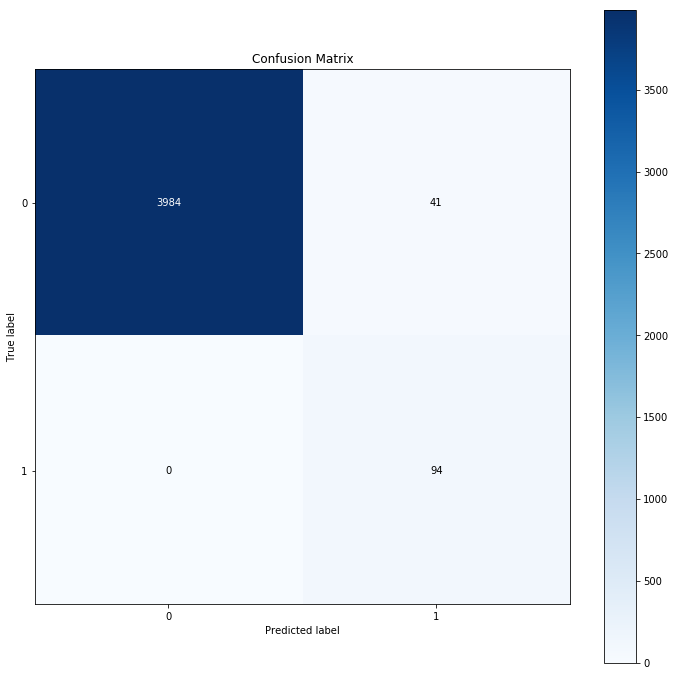

In [61]:
skplt.metrics.plot_confusion_matrix(y_test, 
    Knn_pred_d[2],figsize=(12,12))